In [1]:
# 모듈 임포트
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2, os
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import KFold

In [2]:
# 상수 정의
dataset_path = "E:\\AI_data\\training_set"

str2label = { "bird" : 0,
              "car" : 1,
              "cat" : 2,
              "dog" : 3,
              "fish" : 4 }

In [3]:
# 데이터셋 정의
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data.float()
        self.labels = labels.float()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y

In [4]:
# 데이터셋 처리 함수 정의
def path2tensor(path, label):
    data_x = []
    data_y = []
    
    files = os.listdir(path)
    for f in files:
        f = os.path.join(path, f)
        img = cv2.imread(f).astype(np.float32) / 255
        img = np.transpose(img, (2, 0, 1))
        data_x.append(img)

        y = [0 for i in range(5)]
        y[label] = 1
        data_y.append(y)

    return (data_x, data_y)

In [5]:
data_x = []
data_y = []

for c in ["bird", "car", "cat", "dog", "fish"]:
    result = path2tensor(os.path.join(dataset_path, c), str2label[c])
    data_x += result[0]
    data_y += result[1]

data_x = np.array(data_x)
data_y = np.array(data_y)

In [6]:
data_x.shape

(13955, 3, 128, 128)

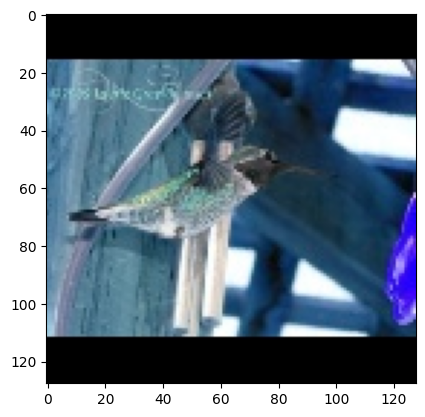

In [7]:
import matplotlib.pyplot as plt
show_img = np.squeeze(data_x[0])  # 배치 차원 제거
plt.imshow(np.transpose(show_img, (1, 2, 0)))  # CHW -> HWC로 변환하여 표시

In [8]:
from torchvision.models import resnet18, ResNet18_Weights
from torch import nn, optim

In [9]:
# 신경망 정의
class Res18Net(nn.Module):
    def __init__(self):
        super(Res18Net, self).__init__()
        self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 5)

    def forward(self, x):
        x = self.model(x)
        return x

In [10]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [12]:
from sklearn.metrics import f1_score

num_epochs = 60
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

history = []
for fold, (train_idx, val_idx) in enumerate(kf.split(data_x)):
    # 데이터 로드
    x_train, x_val = data_x[train_idx], data_x[val_idx]
    y_train, y_val = data_y[train_idx], data_y[val_idx]
    x_train, x_val = torch.tensor(x_train, dtype=torch.float32), torch.tensor(x_val, dtype=torch.float32)
    y_train, y_val = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
    
    train_dataset = MyDataset(x_train, y_train)
    val_dataset = MyDataset(x_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # 모델 설정
    model = Res18Net().to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # history 만들기
    validation_loss = []
    validation_acc = []
    validation_f1 = []
    train_loss = []

    # 훈련 루프
    for epoch in tqdm(range(num_epochs), desc=f"# Fold {fold+1} #"):
        model.train()
        total_train_loss = 0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_train_loss += loss.item()
            loss.backward()
            optimizer.step()
        train_loss.append(total_train_loss / len(train_loader))

        # 검증 루프
        model.eval()
        val_loss = 0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

                preds = torch.sigmoid(outputs) > 0.5
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        validation_loss.append(avg_val_loss)

        all_preds = np.array(all_preds)
        all_targets = np.array(all_targets)

        accuracy = (all_preds == all_targets).mean()
        validation_acc.append(accuracy)

        f1 = f1_score(all_targets, all_preds, average='weighted')
        validation_f1.append(f1)

    history.append([train_loss, validation_loss, validation_acc, validation_f1])

Using device: cuda


# Fold 5 #: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [07:01<00:00,  7.02s/it]


In [13]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [14]:
avg_history = {}
avg_names = ["train_loss", "val_loss", "val_acc", "val_f1"]

if not history or not all(history):
    raise ValueError("History is empty or contains empty folds")

n_folds = len(history)
n_epochs = len(history[0][0])  # Assuming all folds have the same number of epochs

for i, name in enumerate(avg_names):
    # Calculate average across folds for each epoch
    avg_data = np.mean([[fold[i][epoch] for fold in history] for epoch in range(n_epochs)], axis=1)
    avg_history[name] = smooth_curve(avg_data.tolist())

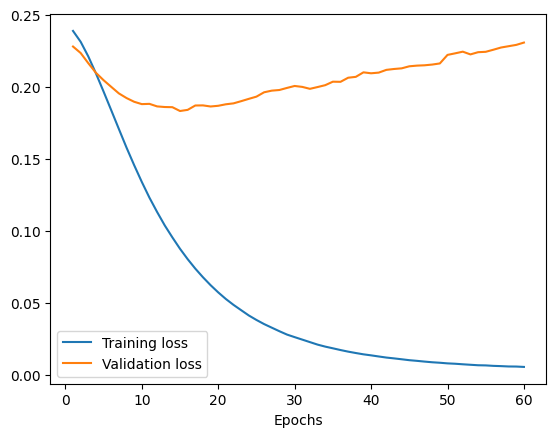

In [15]:
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs+1), avg_history["train_loss"], label='Training loss')
plt.plot(range(1, num_epochs+1), avg_history["val_loss"], label='Validation loss')

plt.xlabel("Epochs")
plt.legend()
plt.show()

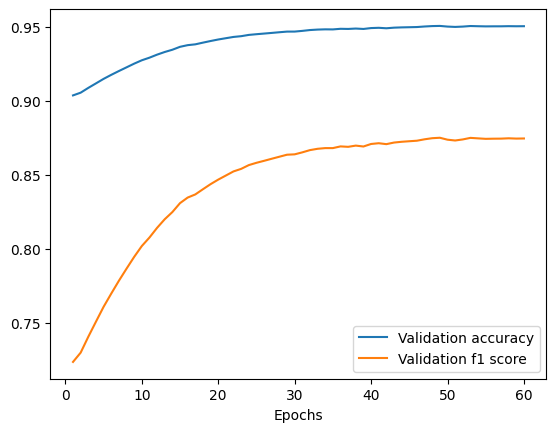

In [16]:
plt.cla()

plt.plot(range(1, num_epochs+1), avg_history["val_acc"], label='Validation accuracy')
plt.plot(range(1, num_epochs+1), avg_history["val_f1"], label='Validation f1 score')

plt.xlabel("Epochs")
plt.legend()
plt.show()

In [ ]:
######## 최종 빌드 ##########

In [19]:
data_x = []
data_y = []

for c in ["bird", "car", "cat", "dog", "fish"]:
    result = path2tensor(os.path.join(dataset_path, c), str2label[c])
    data_x += result[0]
    data_y += result[1]

data_x = np.array(data_x)
data_y = np.array(data_y)

In [20]:
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

num_epochs = 30

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

train_x = torch.tensor(data_x, dtype=torch.float32)
train_y = torch.tensor(data_y, dtype=torch.float32)

train_dataset = MyDataset(x_train, y_train)

dataset_size = len(train_dataset)
labels = y_train.numpy()

train_indices, val_indices = train_test_split(
    range(dataset_size),
    test_size=0.15,
    stratify=labels,
    random_state=42
)

train_loader = DataLoader(Subset(train_dataset, train_indices), batch_size=32, shuffle=True)
val_loader = DataLoader(Subset(train_dataset, val_indices), batch_size=32, shuffle=False)

model = Res18Net().to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

min_loss = None

# 훈련 루프
for epoch in tqdm(range(num_epochs)):
    model.model.train()
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # 검증 루프
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    if not min_loss:
        min_loss = avg_val_loss

    if min_loss > avg_val_loss:
        min_loss = avg_val_loss
        torch.save(model, 'v1.pt')
        print(f"model saved! (val_loss: {min_loss})")

Using device: cuda


  7%|█████▌                                                                             | 2/30 [00:11<02:43,  5.83s/it]

model saved! (val_loss: 0.1826777441321679)


 10%|████████▎                                                                          | 3/30 [00:17<02:37,  5.82s/it]

model saved! (val_loss: 0.13883112799727693)


 23%|███████████████████▎                                                               | 7/30 [00:40<02:12,  5.75s/it]

model saved! (val_loss: 0.11642930737503294)


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [02:52<00:00,  5.74s/it]
